## Spooky Author Identification

The competition dataset contains text from works of fiction written by spooky authors of the public domain: Edgar Allan Poe, HP Lovecraft and Mary Shelley. The data was prepared by chunking larger texts into sentences using CoreNLP's MaxEnt sentence tokenizer, so you may notice the odd non-sentence here and there. Your objective is to accurately identify the author of the sentences in the test set.

#### Data fields
* id - a unique identifier for each sentence
* text - some text written by one of the authors
* author - the author of the sentence (EAP: Edgar Allan Poe, HPL: HP Lovecraft; MWS: Mary Wollstonecraft Shelley)

You can also find the dataset <a href = "https://www.kaggle.com/competitions/spooky-author-identification/overview"> here</a>

***

### Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import Sequential
from keras import layers
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

### Read 'spooky.csv' dataset

In [2]:
df=pd.read_csv('spooky.csv')

In [3]:
df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


### Drop 'id' column

In [4]:
df.drop(columns=['id'],inplace=True)

In [5]:
df

,text,author
0,"This process, however, afforded me no means of...",EAP
1,It never once occurred to me that the fumbling...,HPL
2,"In his left hand was a gold snuff box, from wh...",EAP
3,How lovely is spring As we looked from Windsor...,MWS
4,"Finding nothing else, not even gold, the Super...",HPL
...,...,...
19574,"I could have fancied, while I looked at it, th...",EAP
19575,The lids clenched themselves together as if in...,EAP
19576,"Mais il faut agir that is to say, a Frenchman ...",EAP
19577,"For an item of news like this, it strikes us i...",EAP


### Check for missing values

In [6]:
df.isna().sum()

text      0
author    0
dtype: int64

### Check for duplicates

In [7]:
df.duplicated().sum()

0

### Print some of the text along with its author

In [8]:
for i in range(5):
    print(df['text'][i],'___',df['author'][i])
    print()

This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall. ___ EAP

It never once occurred to me that the fumbling might be a mere mistake. ___ HPL

In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction. ___ EAP

How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair. ___ MWS

Finding nothing else, not even gold, the Superintendent abandoned his attempts; but a perplexed look occasionally steals over his countenance as he sits thinking at his desk. ___ HPL



### Create a function to preproces the text

In [9]:
def preprocess(sentence):
    #removes all the special characters and split the sentence at spaces
    text = re.sub(r"[^a-zA-Z0-9]"," ",sentence).split()
    
    # converts words to lowercase and removes any stopwords
    words = [x.lower() for x in text if x not in stopwords.words('english')]
    
    # Lemmatize the words
    lemma = WordNetLemmatizer()
    word = [lemma.lemmatize(word,'v') for word in words ]
    
    # convert the list of words back into a sentence
    word = ' '.join(word)
    return word

In [10]:
df['text']=df['text'].apply(preprocess)

### Print some of the text after preprocess

In [11]:
for i in range(5):
    print(df['text'][i],'------',df['author'][i])
    print()

this process however afford mean ascertain dimension dungeon i might make circuit return point whence i set without aware fact perfectly uniform seem wall ------ EAP

it never occur fumble might mere mistake ------ HPL

in leave hand gold snuff box caper hill cut manner fantastic step take snuff incessantly air greatest possible self satisfaction ------ EAP

how lovely spring as look windsor terrace sixteen fertile counties spread beneath speckle happy cottages wealthier towns look former years heart cheer fair ------ MWS

find nothing else even gold superintendent abandon attempt perplex look occasionally steal countenance sit think desk ------ HPL



### Check for imbalance in the dataset

In [12]:
df['author'].value_counts()

EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64

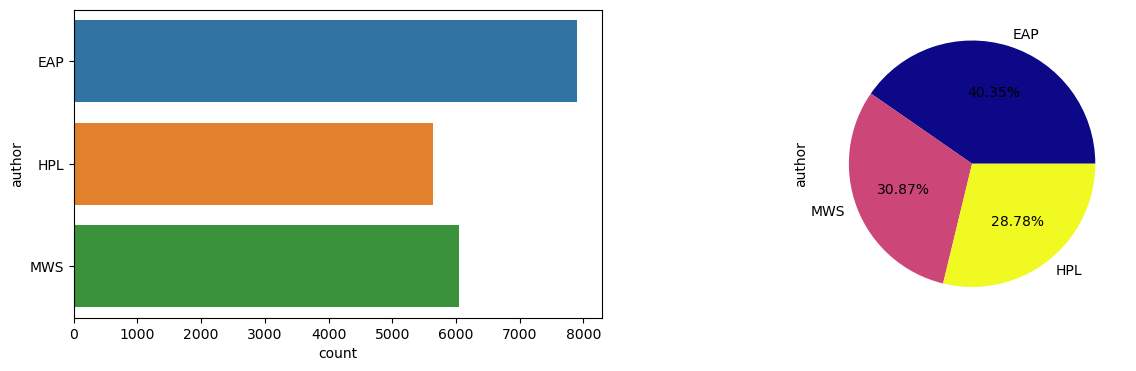

In [13]:
import seaborn as sns
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)

sns.countplot(data=df,y='author')
plt.subplot(1,2,2)
df['author'].value_counts().plot.pie(autopct='%1.2f%%',cmap='plasma')
plt.show()

### Split the dataset into Input & Target Variables

In [14]:
x=df['text']
y=df['author']

### Label Encode our target variables

In [15]:
y=y.map({'EAP':0,'HPL':1,'MWS':2})

In [16]:
y

0        0
1        1
2        0
3        2
4        1
        ..
19574    0
19575    0
19576    0
19577    0
19578    1
Name: author, Length: 19579, dtype: int64

### Create Keras tokenizer object with 5000 max words
* Convert text to sequence
* Add padding

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [17]:
tokenizer=Tokenizer(num_words=5000)

In [18]:
tokenizer.fit_on_texts(x)

In [19]:
vocab_size=len(tokenizer.word_index)+1

In [20]:
def text_encoding(txt):
    # texts_to_sequences Transforms each text in texts to a sequence of integers.
    encoded_docs = tokenizer.texts_to_sequences(txt)
    
    # pad_sequences is used to ensure that all sequences in a list have the same length.
    padded_sequence = pad_sequences(encoded_docs, maxlen=256)    
       
    return padded_sequence

In [21]:
x=text_encoding(x)

### Split the dataset into Training & Testing set

In [22]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.5)

### Create keras Sequential model with GRU layers

In [23]:


model = Sequential()
### Embedding layer
model.add(layers.Embedding(vocab_size, 128))

### GRU layer
### return_sequences: Whether to return the last output in the output sequence, or the full sequence.
model.add(layers.GRU(128,  return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.GRU(128))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(3, activation='softmax'))

### Compile the model

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         2506368   
                                                                 
 gru (GRU)                   (None, None, 128)         99072     
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1

In [25]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

### Train the model

In [26]:
model.fit(x_train,y_train,epochs=10,validation_split=0.2)

Epoch 1/10
245/245 [==============================] - 74s 291ms/step - loss: 0.7937 - accuracy: 0.6366 - val_loss: 0.6424 - val_accuracy: 0.7171
Epoch 2/10
245/245 [==============================] - 79s 324ms/step - loss: 0.3838 - accuracy: 0.8529 - val_loss: 0.6052 - val_accuracy: 0.7426
Epoch 3/10
245/245 [==============================] - 78s 320ms/step - loss: 0.2368 - accuracy: 0.9153 - val_loss: 0.7001 - val_accuracy: 0.7487
Epoch 4/10
245/245 [==============================] - 76s 310ms/step - loss: 0.1638 - accuracy: 0.9453 - val_loss: 0.8333 - val_accuracy: 0.7472
Epoch 5/10
245/245 [==============================] - 79s 322ms/step - loss: 0.1128 - accuracy: 0.9617 - val_loss: 1.0395 - val_accuracy: 0.7477
Epoch 6/10
245/245 [==============================] - 77s 314ms/step - loss: 0.0924 - accuracy: 0.9682 - val_loss: 1.2013 - val_accuracy: 0.7344
Epoch 7/10
245/245 [==============================] - 87s 354ms/step - loss: 0.0588 - accuracy: 0.9791 - val_loss: 1.1767 - val_ac

### Make predictions with X_test

In [28]:
y_pred=model.predict(x_test)

306/306 [==============================] - 18s 58ms/step


### Fetch the index of the higher probable prediction

In [29]:

y_pred=[np.argmax(i) for i in y_pred]

### Evaluate the model

#### Accuracy score

In [31]:
accuracy_score(y_test,y_pred)

0.741879468845761

#### Confusion matrix

<AxesSubplot:>

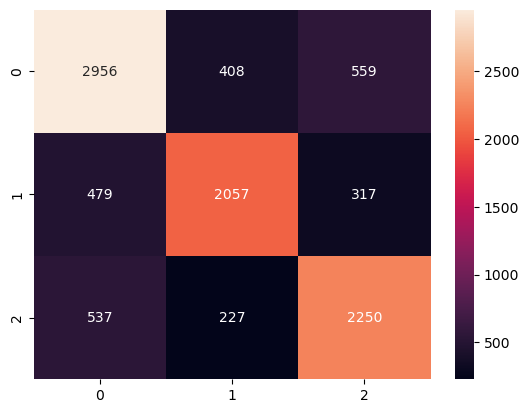

In [38]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d')

#### Classification Report

In [40]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.74      0.75      0.75      3923
           1       0.76      0.72      0.74      2853
           2       0.72      0.75      0.73      3014

    accuracy                           0.74      9790
   macro avg       0.74      0.74      0.74      9790
weighted avg       0.74      0.74      0.74      9790



***